## тестирование стратегии на промежутке дней (год)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

TOKEN = os.getenv("INVEST_TOKEN")

TICKER = 'RNFT'
FIGI = 'BBG00F9XX7H4'

In [ ]:
from trader_bot import ScalpingBot
from historical_data import HistoricalDataHandler

from test_env.client_test_env import ClientTestEnvHelper
from test_env.logger_test_env import LoggerTestEnvHelper
from test_env.time_test_env import TimeTestEnvHelper
from test_env.accounting_test_env import AccountingTestEnvHelper

def test_algorythm(
        last_test_date = '2024-03-15',
        test_days_num = 251,
        profit_steps=5, 
        candles_count=4, 
        sleep_trading=5 * 60, 
        sleep_no_trade=300, 
        always_sell_koef=.5,
        no_operation_timeout_seconds=300,
        do_printing=None
        ):
    
    if do_printing is None:
        do_printing = test_days_num == 1
    
    time_helper = TimeTestEnvHelper()
    
    logger_helper = LoggerTestEnvHelper(time_helper, do_printing=do_printing)
    
    client_helper = ClientTestEnvHelper(TICKER, logger_helper, time_helper)
    client_helper.set_ticker_params(1, 0.1, FIGI, 'RUR')
    
    accounting_helper = AccountingTestEnvHelper(client_helper)
    
    data_handler = HistoricalDataHandler(TOKEN, FIGI, TICKER)
    
    days_list = data_handler.get_days_list(last_test_date, test_days_num)
    
    balance = 0
    success_days = 0
    balance_change_list = []
    operations_cnt = 0
    operations_not_closed_cnt = 0
    operations_cnt_list = []
    
    # закручиваем цикл по датам
    for test_date in days_list:
    
        # прогоняем по дню (-3 часа для компенсации часового сдвига)
        date_from = datetime.strptime(test_date + ' 07:30', "%Y-%m-%d %H:%M")   # 10:30
        date_to   = datetime.strptime( test_date + ' 15:30', "%Y-%m-%d %H:%M")  # 18:30
        
        # задаем параметры дня
        time_helper.set_current_time(date_from)
        
        # создаем бота с настройками
        bot = ScalpingBot(
            TOKEN, 
            TICKER,
        
            profit_steps=profit_steps,
            candles_count=candles_count,
            
            sleep_trading=sleep_trading,
            sleep_no_trade=sleep_no_trade,
            no_operation_timeout_seconds=no_operation_timeout_seconds,
            
            always_sell_koef=always_sell_koef,
        
            time_helper=time_helper,
            logger_helper=logger_helper,
            client_helper=client_helper,
            accounting_helper=accounting_helper,
        )
        
        bot.reset_last_operation_time()
        client_helper.set_candles_list(data_handler.get_candles(test_date))
        
        accounting_helper.reset()
    
        # Использование итератора для вывода каждой пары час-минута
        for dt in data_handler.get_hour_minute_pairs(date_from, date_to):
            # задаем время
            time_helper.set_time(dt)
            
            candle = client_helper.get_candle(dt)
            if candle is None:
                logger_helper.error(f"No candle for {dt}")        
                continue
            
            # задаем текущее значение свечи
            client_helper.set_current_candle(candle)
            
            # анализируем заявки - успешные помечаем
            if bot.buy_order:
                buy_price = client_helper.quotation_to_float(bot.buy_order.initial_order_price)
                low_buy_price = client_helper.quotation_to_float(candle.low)
                if buy_price >= low_buy_price:
                    client_helper.buy_order_executed = True
                    client_helper.buy_order_executed_on_border = buy_price == low_buy_price
        
            if bot.sell_order:
                sell_price = client_helper.quotation_to_float(bot.sell_order.initial_order_price)
                high_sell_price = client_helper.quotation_to_float(candle.high)
                if sell_price <= high_sell_price:
                    client_helper.sell_order_executed = True
                    client_helper.sell_order_executed_on_border = sell_price == high_sell_price
        
            # если пора просыпаться
            if time_helper.is_time_to_awake():
                # print(dt.strftime("%H:%M"))
                # запускаем итерацию торгового алгоритма
                bot.run_iteration()
        
        bot.stop()
        
        operations = len(accounting_helper.deals)
        operations_cnt += operations
        operations_cnt_list.append(operations)
        if client_helper.sell_order_executed % 2 == 1:
            operations_not_closed_cnt += 1
        
        balance_change = round(accounting_helper.sum, 2)
        balance = round(balance + balance_change, 2)
        
        if balance_change > 0:
            success_days += 1
            
        balance_change_list.append(balance_change)
                
    return {
        'balance': balance,
        'balance_change_avg': round(sum(balance_change_list) / test_days_num, 2),

        'days': test_days_num,
        'success_days': success_days,
        'success_p': round(success_days / test_days_num, 2),

        'profit_steps': profit_steps,
        'candles_count': candles_count,
        'sleep_trading': sleep_trading,
        
        'always_sell_koef': always_sell_koef,

        'operations_cnt': operations_cnt,
        'operations_avg': round(sum(operations_cnt_list) / test_days_num, 2),
        'op_not_closed': operations_not_closed_cnt,
        'op_not_closed_avg': round(operations_not_closed_cnt / test_days_num, 2),
    }
        

# print(test_algorythm(
#     last_test_date = '2024-03-15',
#     test_days_num = 5, # 251,
# 
#     profit_steps=5, 
#     candles_count=4, 
# 
#     sleep_trading=5 * 60, 
#     sleep_no_trade=300, 
#     no_operation_timeout_seconds=300,
# ))

results = []

for always_sell_koef_ in [0, 1, 1.5, 2]:
    for candles_count_ in [4]:
        for sleep_trading_ in [1 * 60]:
# for profit_steps in [3, 4, 5, 6]:
#     for candles_count in [3, 4, 5]:
#         for sleep_trading in [1*60, 3*60, 5*60, 7*60, 10*60]:
            res = test_algorythm(
                last_test_date = '2024-03-15',
                test_days_num = 251, # 251,
            
                profit_steps=5, 
                candles_count=candles_count_, 
                
                always_sell_koef=always_sell_koef_,
            
                sleep_trading=sleep_trading_, 
                sleep_no_trade=300, 
                no_operation_timeout_seconds=300,
                
                # do_printing=False,
            )
            print('.', end='')
            results.append(res)
            
sorted_results = sorted(results, key=lambda x: x['success_p'], reverse=True)

print()
for item in sorted_results:
    print(item)

# sorted_results

..

## V5 последние показатели

```
[{'balance': -322.9,
  'balance_change_avg': -1.29,
  'days': 251,
  'success_days': 59,
  'success_p': 0.24,
  'profit_steps': 5,
  'candles_count': 4,
  'sleep_trading': 60,
  'operations_cnt': 5482,
  'operations_avg': 21.84,
  'op_not_closed': 170,
  'op_not_closed_avg': 0.68}]
```

## V4 результаты

```
[{'balance': -327.3,
  'balance_change_avg': -1.3,
  'days': 251,
  'success_days': 58,
  'success_p': 0.23,
  'profit_steps': 5,
  'candles_count': 4,
  'sleep_trading': 60,
  'operations_cnt': 5020,
  'operations_avg': 20.0,
  'op_not_closed': 134,
  'op_not_closed_avg': 0.53}]
```

> {'balance': -193.7, 'balance_change_avg': -0.77, 'days': 251, 'success_days': 65, 'success_p': 0.26, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 300, 'operations_cnt': 1390, 'operations_avg': 5.54, 'op_not_closed': 148, 'op_not_closed_avg': 0.59}
> {'balance': -138.9, 'balance_change_avg': -0.55, 'days': 251, 'success_days': 60, 'success_p': 0.24, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 600, 'operations_cnt': 780, 'operations_avg': 3.11, 'op_not_closed': 112, 'op_not_closed_avg': 0.45}
> {'balance': -327.3, 'balance_change_avg': -1.3, 'days': 251, 'success_days': 58, 'success_p': 0.23, 'profit_steps': 5, 'candles_count': 4, 'sleep_trading': 60, 'operations_cnt': 5020, 'operations_avg': 20.0, 'op_not_closed': 134, 'op_not_closed_avg': 0.53}

In [121]:
sorted_results

[{'balance': -327.3,
  'balance_change_avg': -1.3,
  'days': 251,
  'success_days': 58,
  'success_p': 0.23,
  'profit_steps': 5,
  'candles_count': 4,
  'sleep_trading': 60,
  'operations_cnt': 5020,
  'operations_avg': 20.0,
  'op_not_closed': 134,
  'op_not_closed_avg': 0.53}]

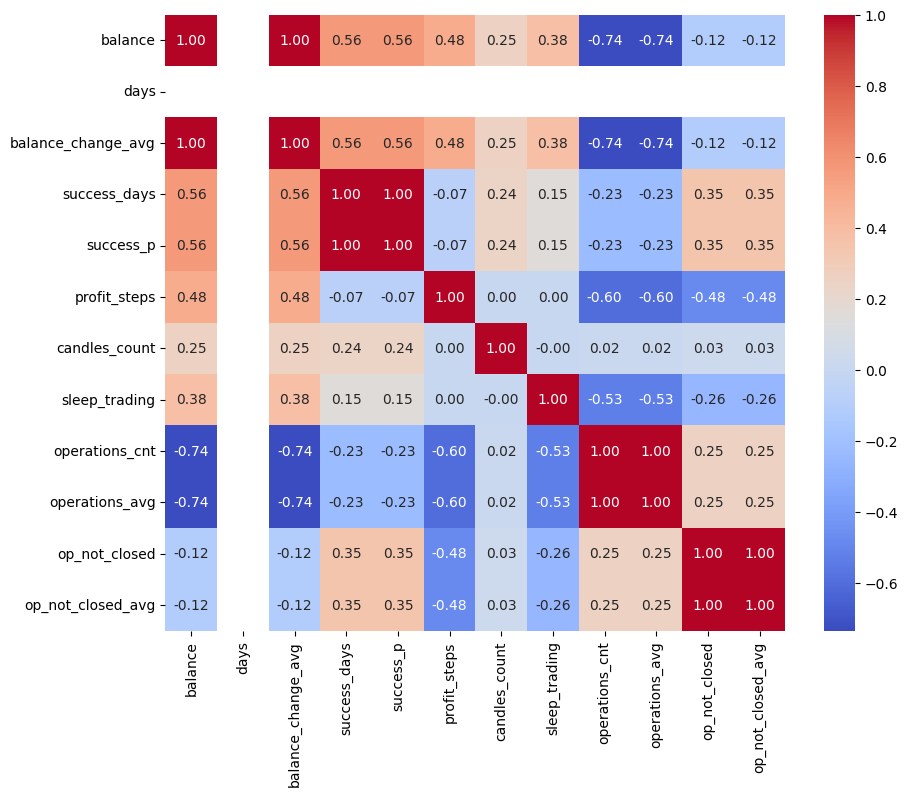

In [107]:
import pandas as pd

# Предположим, что data - это ваш список объектов
data = sorted_results

# Преобразование списка словарей в DataFrame
df = pd.DataFrame(data)

# Вычисление таблицы корреляции
correlation_matrix = df.corr()

# Вывод таблицы корреляции
# print(correlation_matrix)

# Для более наглядного отображения можно использовать seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()